<a href="https://colab.research.google.com/github/Praveen76/Build-a-Forecasting-Model-using-RNN/blob/main/Build_a_Forecasting_Model_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to:

* understand and pre-process the time series data
* understand different Recurrent Neural Networks - SimpleRNN, LSTM, GRU
* implement RNNs for temperature-forecasting
* understand advanced RNN concepts such as recurrent dropout, stacking recurrent layers, and Bi-directional RNNs

## Time Series

A **time series** is a series of data points indexed in time. It is a sequence of observations recorded at regular time intervals. Analysis can be perofrmed on time series data so as to discover patterns, spot anomalies, test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

For examples, different kinds of time series tasks includes:

* **Classification** —Assign one or more categorical labels to a time series. For instance,
given the time series of the activity of a visitor on a website, classify whether the
visitor is a bot or a human.
* **Event detection** —Identify the occurrence of a specific expected event within a
continuous data stream. A particularly useful application is “hot word detection,” where a model monitors an audio stream and detects utterances like “Ok
Google” or “Hey Alexa.”



## Temperature-forecasting

**Problem statement**:

Given a time series of hourly measurements of various atmospheric parameters, **predict** the temperature 24 hours in the future.


**Goal**:

To demonstrate that RNNs perform better than Dense or Convolutional Networks for time-series data.

## Dataset Description

We will be using Jena Climate dataset recorded by the Max Planck Institute for Biogeochemistry. The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per 10 minutes.

Features includes:

* ***Date Time***:	date-time reference
* ***p (mbar)***: the pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
* ***T (degC)***: temperature in Celsius
* ***pot (K)***:	temperature in Kelvin
* ***Tdew (degC)***:	temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
* ***rh (%)***:	relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
* ***VPmax (mbar)***:	saturation vapor pressure
* ***VPact (mbar)***:	vapor pressure
* ***VPdef (mbar)***: vapor pressure deficit
* ***sh (g/kg)***:	specific humidity
* ***H2OC (mmol/mol)***:	water vapor concentration
* ***rho (g/m ** 3)***:	airtight
* ***wv (m/s)***:	wind speed
* ***max. wv (m/s)***:	maximum wind speed
* ***wd (deg)***:	wind direction in degrees

In [1]:
#@title Download the dataset
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/jena_climate_2009_2016.csv
print("Dataset downloaded successfully!")
!ls | grep ".csv"

--2024-03-18 06:22:54--  https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/jena_climate_2009_2016.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [application/octet-stream]
Saving to: ‘jena_climate_2009_2016.csv’

jena_climate_2009_2 100%[===================>]  41.16M  8.81MB/s    in 5.6s    

2024-03-18 06:23:01 (7.37 MB/s) - ‘jena_climate_2009_2016.csv’ saved [43164220/43164220]

Dataset downloaded successfully!
jena_climate_2009_2016.csv


### Importing Required Packages

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

### Load the Dataset

In [3]:
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.shape

(420551, 14)

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Visualize the data

Important features to forecast temperature are `T (degC)` (temperature), `p (mbar)` (pressure), and `rho (g/m**3)` density of the air.

Let's see the variation in these features, and also visualize a small window of these series.

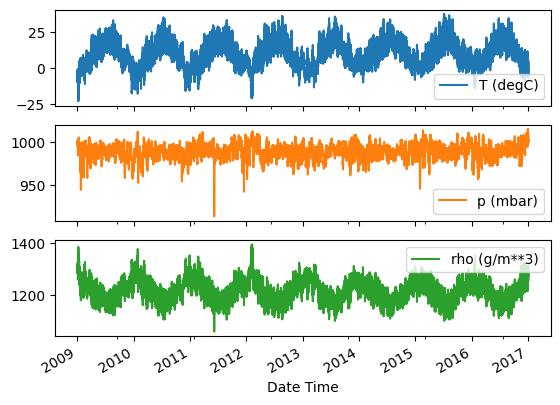

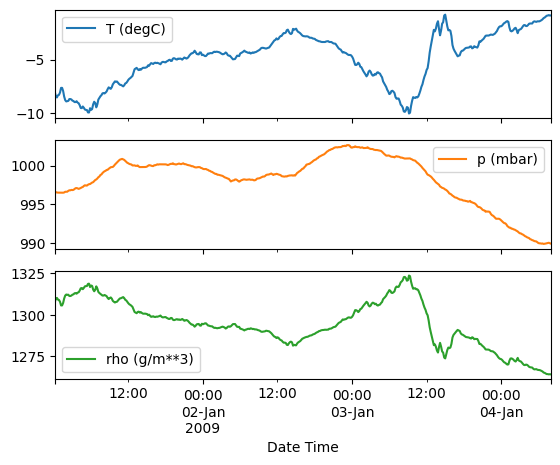

In [6]:
# Visualize the data
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Lets zoom in to a smaller time-window
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Note: Data is recorded every 10 minutes, 6 data points in 60 minutes, therefore 24 × 6 = 144 data points per day

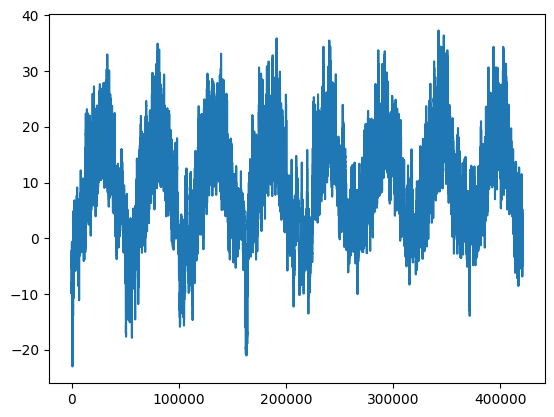

In [7]:
# Plotting the temperature timeseries
temperature = df['T (degC)'] # extract out the temperature data
plt.plot(range(len(temperature)), temperature)

In [8]:
# Convert data to np array
raw_data = np.array(df)           # raw_data is a np array
print(raw_data.shape)
# Q: how many features are there? A: 14

(420551, 14)


0   -8.02
1   -8.41
2   -8.51
3   -8.31
4   -8.27
Name: T (degC), dtype: float64


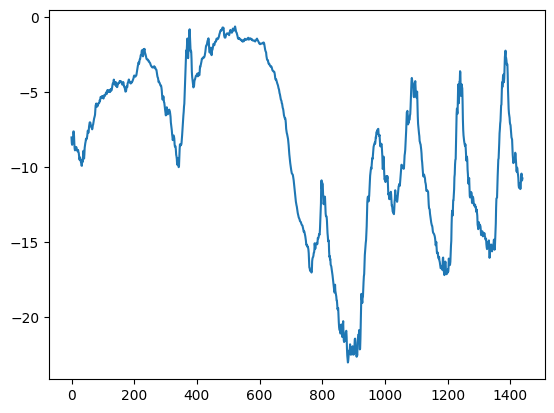

In [9]:
# Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440]) # 144 data points in one day, 1440 data points in 10 days
print(temperature[:5])

### Get the split index for train, validation and test samples

In [10]:
# Compute the number of samples for each data split
num_train_samples = int(0.5 * len(raw_data))     #Q: What is len(raw_data) #A: 420551
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples      #Q: approx how many test samples? #A: apx 25%

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


### Pre-processing the data

Data Normalization

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)     # Q: axis=0 means? Is mean a vector? #A: temporal axis; mean is a vector of size (14,)
std = raw_data[:num_train_samples].std(axis=0)       # Standard Deviation

raw_data -= mean
raw_data /= std

# Q: On what data was the mean and std computed? #A: Train data
# Q: On what data is standardization tranformation applied? #A: On all the data

[-1.92080466 -1.96527448 -1.976677   ... -1.36664229 -1.48864923
 -1.55592409]


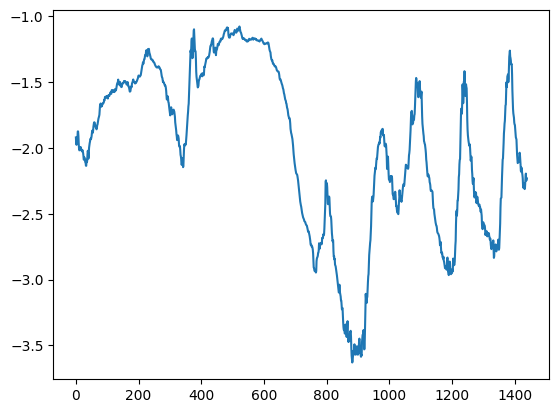

In [12]:
# plot the normalized temperature data
print(raw_data[:,1])  # temperature data
plt.plot(raw_data[:1440,1])

#Q: What is the difference between the below plot and the prev one? #A: Scale, visible difference in y-axis
#Q: Does the plot look like it has 0 mean? Yes/No/Why? #A: No. but this not the full data.

The time series data is available from sensors and web but how to get datasets, what is the input and the label?

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.


To make apt datasets, keras [utils](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) will be used, called


```
timeseries_dataset_from_array()
```


In the subsequent two code cells we are trying to demonstrate the working of `timeseries_dataset_from_array()` function from keras.

Using two examples we will see how time series data can be prepared which can be fed to a RNN model.

Later the same concept will be used to prepare the final data.

### Examples to see how time series data can be prepared to feed the RNN

#### Time series data preparation: Example 1

In [13]:
int_sequence = np.arange(20)
print(f"Original Timeseries sequence: {int_sequence}\n")
print(f"data = int_sequence[:-3]={int_sequence[:-3]}\n")
print(f"targets= int_sequence[3:] = {int_sequence[3:]}\n")

# returns sequences and corresponding targets
dummy_dataset = keras.utils.timeseries_dataset_from_array(
                                      data=int_sequence[:-3],
                                      targets=int_sequence[3:],
                                      # The next 3 arguments are for you to manipulate the data (input)
                                      sequence_length=3,
                                      sampling_rate = 2,
                                      sequence_stride = 2, # stride applied to both data and targets
                                      # batch_size=2,  # see in next cell
                                  )


for inputs, targets in dummy_dataset:
    # print(inputs, targets)
    print(inputs.shape)
    for i in range(inputs.shape[0]): # range(batch_size)
        print([int(x) for x in inputs[i]], int(targets[i]))

Original Timeseries sequence: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

data = int_sequence[:-3]=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

targets= int_sequence[3:] = [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

(7, 3)
[0, 2, 4] 3
[2, 4, 6] 5
[4, 6, 8] 7
[6, 8, 10] 9
[8, 10, 12] 11
[10, 12, 14] 13
[12, 14, 16] 15


For intuition, read [here](https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/)

Inputs and targets look like this:

[0, 2, 4] : 3

[1, 3, 5] : 4

[2, 4, 6] : 5

...

...

#### Time series data preparation: Example 2

In [14]:
int_sequence = np.arange(20)
print(f"Original Timeseries sequence: {int_sequence}")
print(f"data = int_sequence[:-3]={int_sequence[:-3]}")
print(f"targets= int_sequence[3:] = {int_sequence[3:]}")

dummy_dataset = keras.utils.timeseries_dataset_from_array(
                                      data=int_sequence[:-3],       #Q: What is the effect of the 3 #A: maintains delay of 3 between last 'data' entry and corresponding target
                                      targets=int_sequence[3:],
                                      # The next 3 arguments are for you to manipulate the data (input)
                                      sequence_length=5,
                                      # sampling_rate = 2,
                                      # sequence_stride = 3,
                                      # batch_size=2,
                                      # shuffle = True
                                  )


for inputs, targets in dummy_dataset:
    print(inputs)
    print(targets)
    print(f"\n inputs.shape = {inputs.shape }")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


Original Timeseries sequence: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
data = int_sequence[:-3]=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
targets= int_sequence[3:] = [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
tf.Tensor(
[[ 0  1  2  3  4]
 [ 1  2  3  4  5]
 [ 2  3  4  5  6]
 [ 3  4  5  6  7]
 [ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 12]
 [ 9 10 11 12 13]
 [10 11 12 13 14]
 [11 12 13 14 15]
 [12 13 14 15 16]], shape=(13, 5), dtype=int64)
tf.Tensor([ 3  4  5  6  7  8  9 10 11 12 13 14 15], shape=(13,), dtype=int64)

 inputs.shape = (13, 5)
[0, 1, 2, 3, 4] 3
[1, 2, 3, 4, 5] 4
[2, 3, 4, 5, 6] 5
[3, 4, 5, 6, 7] 6
[4, 5, 6, 7, 8] 7
[5, 6, 7, 8, 9] 8
[6, 7, 8, 9, 10] 9
[7, 8, 9, 10, 11] 10
[8, 9, 10, 11, 12] 11
[9, 10, 11, 12, 13] 12
[10, 11, 12, 13, 14] 13
[11, 12, 13, 14, 15] 14
[12, 13, 14, 15, 16] 15


This enhances the working and understanding of the utility function. The same can be used to prepare the final dataset.

### Final data preparation: using train, test and validation indexes

In [15]:
# Instantiating datasets for training, validation, and testing

# Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
sampling_rate = 6  # every 6th sample of the original sequence is a sample after an hour


sequence_length = 120 #Q: How many days worth data in a sequence? #A: 5 Days

# The target for a sequence will be the temperature 24 hours after the end of the sequenc
delay = sampling_rate * (sequence_length + 24 - 1)

batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],          # Q: What is this argument? #A: data
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Q: Do we have to normalise the test data or is it already done?

In [16]:
# Inspecting the output of one of our datasets
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Computing the non-machine-learning baseline

Computing the common-sense baseline MAE

Prediction based on the assumption that the temperature changes periodically.

Hence, the temperature prediction of 24 hrs later should be equal to the temperature right now

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        #Q: What is the shape of samples? What is idx 1? # A: (256, 120, 14), ; idx 1 means temperature. See dataframe.
        preds = samples[:, -1, 1] * std[1] + mean[1]  #Q: Why multiply by std and add with mean?
        #Q: What are the next 2 lines doing?
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44


The Test MAE is 2.62. It means our naive model is expected to give a prediction which is off by 2.62 deg on average.

### Train a Dense Neural Network

In [ ]:
# **Training and evaluating a densely connected model**

# define input layer: relate to how you would pass image data to a dense layer
# Remember: Shape of an input batch: (256, 120, 14)
# Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) #Q: What is raw_data.shape[-1]? #A: Last index, i.e., no. of features = 14

x = layers.Flatten()(inputs) #Q: Why flatten? # A: Input is in the form of matrix
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Define the callback function and compile the model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

Train and save the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,  # Initially keep epochs = 3
                    validation_data=val_dataset,
                    callbacks=callbacks)

Load the saved model and make a prediction

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Plot the results

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The dense network has not done very well. Achieves a validation loss of 2.6.

Why?


*   The hypothesis space is inappropriate
      - perhaps too large
      - looking for a window-wise global pattern
*   An example of the poweful nature of
      - good feature engineering
      - domain knowledge



## 1D Convolutional model

We don't have an image and we do not necessarily need one.

We will use 1D convolutions.
  - try to learn local patterns in the signal/sequence

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT5VZ8P0REZ7GEUKFsTT_d5SLiGjOpoBk46jSn0kPm1b7yqtTNwXNRi0G84dv_1b1oP3Oo&usqp=CAU" width=450px>

Find a 1D Convolutional animation [here](https://www.google.com/url?sa=i&url=https%3A%2F%2Fe2eml.school%2Fconvolution_one_d.html&psig=AOvVaw2bFkQnxEG3jAUIpT8tXlYs&ust=1654344663003000&source=images&cd=vfe&ved=0CAwQjRxqFwoTCJDegqmgkfgCFQAAAAAdAAAAABAD)


In [ ]:
# Model Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu", input_shape=(120,14))(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

plot_model(model, show_shapes=True)


In [ ]:
# Train and save the best model
history = model.fit(train_dataset,
                    epochs=10,   # Initiallly keep epochs = 2
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras") # Load the saved model
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Make a prediction

**Built-in RNN layers:**

There are three built-in RNN layers in Keras:

* **keras.layers.SimpleRNN**, a fully-connected RNN where the output from previous timestep is to be fed to next timestep.


* **keras.layers.GRU**, first proposed in Cho et al., 2014.

* **keras.layers.LSTM**, first proposed in Hochreiter & Schmidhuber, 1997.

## Understanding Recurrent Neural Networks

Sequence Learning problems:
  


*   Inputs are no longer independent
*   Input sizes not fixed. Ex- Length of sentences


So an RNN should take care of:

*   Dependence between inputs
*   Variable no. of inputs
*   Function executed at each time must be the same



**NumPy implementation of a simple RNN**

<img src="https://drive.google.com/uc?export=view&id=1LYt9XbBtWCDQ7lIW1jTAPvB9PJh88dtd" width=500px>

<img src="https://drive.google.com/uc?export=view&id=1u68eJS1dhySV9cqqMN1ZS6PsA7Sexlpt" width=300px>

<br>
<img src="https://drive.google.com/uc?export=view&id=1GV_Z-KcwXq8x0WwLOh_rVubH-okKZnXn" width=250px>



In [ ]:
timesteps = 100   #:number of timesteps in the input sequence
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
U = np.random.random((output_features, input_features))
W = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(U, input_t) + np.dot(W, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0) # Q: seq/vec-to-seq/vec #A: seq-to-seq due to stack

Notice the sequential nature of computation. We will discuss this later.


### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
model = keras.Model(inputs, outputs)
print(outputs.shape)
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
16*14 + 16*16 + 16

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs) # return_seq = False
model = keras.Model(inputs, outputs)
print(outputs.shape) # see output
model.summary()
plot_model(model, show_shapes=True)

**An LSTM layer**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.LSTM(16, return_sequences=False)(inputs) # return_seq = False
model = keras.Model(inputs, outputs)
print(outputs.shape) # see output
model.summary()
plot_model(model, show_shapes=True)

**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
model = keras.Model(inputs, outputs)
model.summary()
plot_model(model, show_shapes=True)

Training a simple LSTM architecture

In [ ]:
# Model Architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Define the callback function and compile the model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

Train and save the best model

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,             # Initially keep epochs=3
                    validation_data=val_dataset,
                    callbacks=callbacks)

Load the saved model and make a prediction

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

The test MAE is 2.57


*   Slightly better than it's Dense counterpart!

*   Easy to use. Just a line of code.

*   We can do much better. But we will not spend much time on training RNN based architecture. Instead we will invest that time on Transformers.






**Stacking RNN layers**

<img src="https://drive.google.com/uc?export=view&id=1bPs5kUdqMvpXTOeZwldX1VE_GFx0W8Vt" width=550px>

In [ ]:
# Architecture
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs) # Q: can return_seq be False here? # A: NO. It will throw error.
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)
print(outputs.shape)
model.summary()

In [ ]:
16*16 + 16*16 + 16

## Advanced use of recurrent neural networks



*   Recurrent dropout
*   Stacking recurrent layers
*   Bi-directional RNNs



### Using recurrent dropout to fight overfitting

Key Idea: The dropout pattern should remain the same across time.


In [ ]:
# Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

How is the loss defined?

Especially for a seq-to-seq RNN model?

<img src="https://drive.google.com/uc?export=view&id=1LYt9XbBtWCDQ7lIW1jTAPvB9PJh88dtd" width=500px>

### Stacking recurrent layers

We've already seen this. But repeating an example to show GRU.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) #Q: why ret_seq =True? #A: Stacked GRUs
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=50,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)
# model = keras.models.load_model("jena_stacked_gru_dropout.keras")
# print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using Bi-directional RNNs

![picture](https://miro.medium.com/max/766/0*ZsTT3zzTNGF-6OsR.jpg)

Key Idea: Learn temporal patterns in both directions

Found to work well with text data.

In [ ]:
# Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset)
model = keras.Model(inputs, outputs)
print(outputs.shape)
model.summary()

Compare it with a single LSTM layer

In [ ]:
# Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Bidirectional(layers.LSTM(16))(inputs)
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset)
model = keras.Model(inputs, outputs)
print(outputs.shape)
model.summary()

Note on runtime performance of RNNs:




*   Small RNNs run faster on CPU

*   Large RNNs can benefit from GPU

*   GPU support not offered by cuDNN when using functionalities that are not optimized. E.g. Recurrent Dropout.

*   Alternative: Unroll = True
  - Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences

* Dropout
  * The Dropout layer randomly sets input units to 0 with a frequency of rate (eg. 0.2 below i.e. 20% nodes to be dropped randomly in the given layer) at each step during training time, which helps prevent overfitting. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer. This is in contrast to setting trainable=False for a Dropout layer.
  
*   Caveat: Sequence length must be known apriori







